In [2]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from functools import partial
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score as recall
from sklearn.metrics import precision_score as precision
from sklearn.metrics import f1_score as f1
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import cohen_kappa_score as kappa_score
from sklearn.metrics import classification_report
import pickle
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import KFold
import plotly.plotly as py
import plotly.graph_objs as go
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2, SelectPercentile
import matplotlib.pyplot as plt

folds = 5
kf = KFold(n_splits=folds)

def xfrange(start, stop, step):
    i = 0
    while start + i * step < stop:
        yield start + i * step
        i += 1

In [3]:
def getclasscount(Y_train):
    classes = list(set(Y_train))
    print classes
#     class_name = ['article', 'help', 'shop', 'public_portrayals_companies_and_institutions', 'discussion', 'link_collection', 'downloads', 'private_portrayal_personal_homepage', 'other']
    class_name = ['public_portrayals_companies_and_institutions', 'article', 'link_collection', 'discussion', 'shop']
    class_counts = [0]*len(class_name)
    for i in Y_train:
        class_counts[int(i)] += 1
    return [(class_name[int(i)], class_counts[int(i)]) for i in classes]    

def Getclasscount(Y_train):
    classes = list(set(Y_train))
    print classes
    class_counts = {}
    for i in Y_train:
        if not class_counts.get(i):
            class_counts[i] = 0
        class_counts[i] += 1
    return class_counts




In [5]:
def stats(y_test, y_pred):
    
    report1 = kappa_score(y_test, y_pred)   

    report2 = classification_report(y_test, y_pred)
    print '\n clasification report:\n', report2
    print '\n confussion matrix:\n',confusion_matrix(y_test, y_pred)
    return report1,report2

In [6]:
# biased learning, most of thr predictions were articles, 
# as it has the maximum count in training set
from sklearn.svm import SVC

svm = SVC(class_weight='balanced',C=1e10, gamma='auto')

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

from sklearn.neural_network import MLPClassifier

# nodes = [512,256,32]
nodes = [128,32]
print 'nodes=', nodes
mlp = MLPClassifier(hidden_layer_sizes=nodes)
# mlp = MLPClassifier(hidden_layer_sizes=nodes,learning_rate='adaptive',batch_size=1000,max_iter=100,verbose=True,early_stopping=True)

from sklearn.ensemble import GradientBoostingClassifier
gbdt = GradientBoostingClassifier(n_estimators=100,max_depth=3,verbose=0)

nodes= [128, 32]


In [7]:
import csv
X = []


# read data
# with open('webcred_features_expanded.csv','rb') as f:
with open('../data/dump/health/webcred_features_expanded.csv','rb') as f:
    data = csv.reader(f, delimiter=',')
    for line in data:
        X.append(line)

        
tag = X[0].index('genre')

# Y = [i[tag] for i in X]
# Y = Y[1:]
# X = [row[:tag]+row[tag+1:] for row in X]


features = X[0]
del features[tag]

print 'Features Count=' ,
print len(features)

X = X[1:]
        

X_2 = []
Y = []
article_count = 0
portrayal_count = 0
link_collection = 0

# class_name = ['article', 'help', 'shop', 'public_portrayals_companies_and_institutions', 'discussion', 'link_collection', 'downloads', 'private_portrayal_personal_homepage', 'other']
class_name = ['public_portrayals_companies_and_institutions', 'article', 'link_collection', 'discussion', 'shop']
count = {i:0 for i in class_name}

class_count_threshold = 20000

for index, row in enumerate(X):

    genre = row[tag]

    # removing broken_links and other
    if genre in [
#                 '8',
                 '4',
#                     '6',
#                     '1'
                ]:
        continue
    
    temp = []    
    for index, item in enumerate(row):
        if index==tag:
            
            try:
                count[class_name[int(item)]]+=1
#                 count[item]+=1
#                 print item
            except:
                print item
                break

            if count[class_name[int(item)]]>class_count_threshold:
#             if count[item]>class_count_threshold:
                    temp = []
                    break
#             if item=='0':
#                 article_count += 1
#                 if article_count>100:
#                     temp = []
#                     break
#             elif item=='3':
#                 portrayal_count += 1
#                 if portrayal_count>100:
#                     temp = []
#                     break
#             elif item=='5':
#                 link_collection += 1
#                 if link_collection>100:
#                     temp = []
#                     break

            Y.append(item)    
        else:    
            # fill empty cells with 0 
            if item is not '':
                item = float(item)
            else:
                item = 0.0
            temp.append(item)
    if temp:        
        X_2.append(temp)
    
X = X_2

X = np.asarray(X)
Y = np.asarray(Y)
Y = np.ravel(Y)

print 'Sample size=' ,
print len(Y)

# X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# print 'X_train >>' + str(X_train.shape) + ' Training data dimension'
# print 'Y_train >>' + str(Y_train.shape) + ' Training data labels'

# print 'X_test >>' + str(X_test.shape) + ' Test data dimension'
# print 'Y_test >>' + str(Y_test.shape) + ' Test data labels'  

Features Count= 230
Sample size= 193


In [8]:
print 'Training counts'
getclasscount(Y)
# Getclasscount(Y)
# print 
# print 'Testing counts'
# print getclasscount(Y_test)

Training counts
['1', '0', '3', '2']


[('article', 56),
 ('public_portrayals_companies_and_institutions', 107),
 ('discussion', 4),
 ('link_collection', 26)]

In [9]:
# Remove features which have same value across all samples

from sklearn.feature_selection import VarianceThreshold
# threshold>> Defaults to 0.0, e.g. only remove features with the same value in all samples
sel = VarianceThreshold(threshold=0.1)
X_var = sel.fit_transform(X,Y)
# X_test_var = sel.transform(X_test)

print 'After variance thresholding'
print str(X_var.shape) + ' Training data dimension'
# print str(Y_train.shape) + ' Training data labels'

# print str(X_test_var.shape) + ' Test data dimension'
# print str(Y_test.shape) + ' Test data labels'  

After variance thresholding
(193, 115) Training data dimension


In [10]:
# name of selected features based on Variance

selected_features = sel.get_support(indices=True)
print selected_features
# print [features[feats] for feats in selected_features]

[  2   3   4   7   9  11  13  14  15  17  18  20  25  26  28  29  33  41
  42  43  48  50  53  55  56  57  60  61  63  64  66  67  68  69  72  73
  75  77  79  81  85  87  88  90  93  94  97  99 101 102 104 105 106 107
 109 110 111 112 113 118 119 121 122 124 125 127 128 131 135 137 138 141
 144 146 147 148 152 155 159 160 161 162 163 167 168 171 175 177 181 182
 183 184 186 187 189 190 194 196 197 198 200 201 202 203 204 209 210 212
 213 214 222 223 225 227 229]


In [11]:
# ANNOVA scores for each feature

# skb = SelectPercentile(f_classif,percentile=20)
# X_skb = skb.fit_transform(X_var,Y_train)
# X_test_skb = skb.transform(X_test_var)
annova,pval = f_classif(X_var,Y)
print annova.shape
# print X_test_skb.shape
# print skb.scores_
# print skb.get_support(indices=True)
# print annova


(115,)


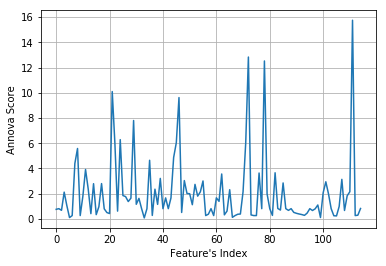

In [11]:
plt.plot(annova)
plt.grid(True)
plt.ylabel('Annova Score')
plt.xlabel("Feature's Index")
plt.show()

In [12]:
# Generate Mutual Information gain

# mkb = SelectKBest(mutual_info_classif,k=200)
# X_mkb = mkb.fit_transform(X_train,Y_train)
# X_test_mkb = mkb.transform(X_test)
mig = mutual_info_classif(X_var,Y,n_neighbors=5)
print mig.shape
# print X_test_mkb.shape
# print skb.scores_
# print mkb.get_support(indices=True)

# features[selected_features[np.argmax(mig)]]

(115,)


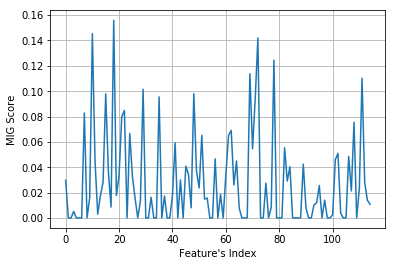

In [13]:
plt.plot(mig)
plt.grid(True)
plt.ylabel('MIG Score')
plt.xlabel("Feature's Index")
plt.show()

In [13]:
# Select features with ANNOVA scores above 5
def build_skb(score):
    X_skb = X_var[:,annova>=score]
#     X_test_skb = X_test_var[:,annova>=score]
    
    
    print 'Annova Score ' + str(score)
    print 'Feature Count ' + str(X_skb.shape[1])
    
#     feats = [elem for index, elem in enumerate(selected_features) if annova[index]>=score]
#     print [features[i] for i in feats]
#     print

    return X_skb

# Select features with Mutual Information gain above 0.05
def build_mkb(score):
    X_mkb = X_var[:,mig>=score]
#     X_test_mkb = X_test_var[:,mig>=score]

    print 'MIG Score ' + str(score)
    print 'Feature Count ' + str(X_mkb.shape[1])

#     feats = [elem for index, elem in enumerate(selected_features) if mig[index]>=score]
#     print [features[i] for i in feats]
#     print
    
    return X_mkb

In [14]:
# under sampling
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids

# cluster sample
ccsampling = ClusterCentroids(random_state=45,sampling_strategy='all')

# random sample 
russampling = RandomUnderSampler(random_state=0)

# print 'feature selection- none'
# print "initial dimension of matrix"
# print str(X_train.shape) + ' Training data dimension after feature selection'
# print str(Y_train.shape) + ' Training labels'

# print 'After random under sampled'
# X_train_rus, Y_train_rus = russampling.fit_sample(X_train, Y_train)
# print str(X_train_rus.shape) + ' Training data dimension'
# print str(Y_train_rus.shape) + ' Training labels'

# getclasscount(Y_train_rus)

# print 'After cluster sampling'
# X_train_cc, Y_train_cc = ccsampling.fit_sample(X_train, Y_train)
# print str(X_train_cc.shape) + ' Training data dimension'
# print str(Y_train_cc.shape) + ' Training labels'

# getclasscount(Y_train_cc)

# more likely ccsampling is better over russampling

In [17]:
# over sampling
from imblearn.over_sampling import SMOTE
smsampling = SMOTE(random_state=2,k_neighbors=1)

# print "initial dimension of matrix"
# print str(X_mkb.shape) + ' Training data dimension after feature selection'
# print str(Y_train.shape) + ' Training labels'

# X_mkb_ros, Y_train_ros = smsampling.fit_sample(X_mkb, Y_train)

# print 'After Oversampling'
# print str(X_mkb_ros.shape) + ' Training data dimension'
# print str(Y_train_ros.shape) + ' Training labels'

# getclasscount(Y_train_ros)

In [15]:
features_reduced_data = {
#     'unreduced':X 
#     'variance':X_var, 
    'Annova':'build_skb', 
#     'Mutual Info':'build_mkb'
}

In [18]:
sampling_clusters = {
#     'cluster sampling': ccsampling, 
    'over sampling': smsampling
}

In [22]:
training_models = {
#     'svm':svm,
#     'LogisticRegression':lr, 
#     'neural networks':mlp,
    'GradientBoostingClassifier':gbdt
}

In [24]:
# CLassifier Function
def train_clf(x,y, clf, model_name):
        
    for sample_name, sample_func in sampling_clusters.items():
        

#         print sample_name
        kf.get_n_splits(x)
        training = 0
        testing = 0
        x, y = sample_func.fit_sample(x,y)
        
        print getclasscount(y)
        return
                        
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

        clf.fit(x_train,y_train)    
        train = clf.score(x_train, y_train)
        test = clf.score(x_test, y_test)
        
        print 'Training Accuracy ' + str(train)
        print 'Testing Accuracy ' + str(test*100)

        if test>=0.8:
            y_pred = clf.predict(x_test)

            kappa_score, classification_report = stats(y_test, y_pred)
        
        return test
        
        for train_index, test_index in kf.split(x):

            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]

            clf.fit(x_train,y_train)

            train = clf.score(x_train, y_train)
            test = clf.score(x_test, y_test)
            
            training += train
            testing += test
            
            print 'Training Accuracy ' + str(train)
            print 'Testing Accuracy ' + str(test*100)


            
            if test>=0.8:
                y_pred = clf.predict(x_test)

                kappa_score, classification_report = stats(y_test, y_pred)
    #             getclasscount(y_test)
            
        


            print '--------------------------------------------------------------'
        return testing/folds*100.0
        if testing/10>=0.8:
#             print sample_name
#             print 'Training Accuracy ' + str(training/10)
#             print 'Testing Accuracy ' + str(testing/10)
            print str(training/10)
            print str(testing/10)



        
#     with open('training.pkl','a') as f:
#         pickle.dump(kappa_score, f)
#         pickle.dump(classification_report, f)

In [25]:
data_graph = []

for model_name, model_func in training_models.items():

    print model_name

    for name,data in features_reduced_data.items():

        print name
        testing = []
        feature_count = []

        if isinstance(data,str):
            # perform k-fold training and testing modelling
            for i in xfrange(7.5,7.6,0.5):
#             for i in xfrange(0.02,0.16,0.02):
#                 print i
                x = eval(data)(i)

                testing.append(train_clf(x, Y, model_func, model_name))
                feature_count.append(x.shape[1])

                # train_clf(x_train, y_train, x_test, y_test, model_func, model_name)
#                 print


        data_graph.append(go.Scatter(
            x = feature_count,
            y = testing,
            mode = 'lines',
            name = model_name
        ))                
   
    print '--------------------------------------------------------------'


# Edit the layout
layout = dict(title = 'Testing Accuracy across Models for various {0} Filtering'.format(name),
              xaxis = dict(title = 'Feature Count'),
              yaxis = dict(title = 'Testing Accuracy (%)'),
              )

fig = dict(data=data_graph, layout=layout)    

py.iplot(fig, filename='line-mode')

# done
#get report of 4k pages
#repeat the exp. with individual csv of serc labels
#. Mohit 150, 

# done
#calculate gcs for new pages >> in progress
#calculate similarity score >>
#     input security group URLs
#        WIKI-SEED URL, C3 in progress




GradientBoostingClassifier
Annova
Annova Score 7.5
Feature Count 6
['1', '0', '3', '2']
[('article', 107), ('public_portrayals_companies_and_institutions', 107), ('discussion', 107), ('link_collection', 107)]
--------------------------------------------------------------
High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~agrawalshriyansh05/0 or inside your plot.ly account where it is named 'line-mode'
